# ImageNet - Human Study Analysis

In [1]:
DATA_SET = 'ImageNet'

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd
import numpy as np

In [3]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

# Reading Data

In [4]:
df = pd.read_csv('../data/ImageNet-Human-Study-Summary.csv')

In [5]:
df.head(5)

,UID,Query,Prior Knowledge,Counter balance,Group Known,Group Unknown,Validation Reaction Time,Test Reaction Time,DATE,Group Validation Correct,Group Validation Incorrect,ImageNet,Correctness,User Accuracy,User Corrects,Method,GroundTruth,Parent-lvl12,Parent-lvl13,Parent-lvl14,ClassifierCorrectness,DifficultyLevel,ConfidenceScore,ResNet-Prediction,KNN-Prediction,EMD-Prediction,CHM-Prediction,ResNet-Conf,KNN-Conf,EMD-Conf,CHM-Conf,Real GTs,Real WNIDs,Parent-lvl12_real,Parent-lvl13_real,Parent-lvl14_real
0,6386009,ILSVRC2012_val_00027121.JPEG,0,15,15,7,677682.700001,340827,2022-05-01 00:17:34.793,10,0,22,1,0.733333,22,CHM-NN,n02112350,carnivore,canine,dog,1,Easy,1.0,keeshond,keeshond,keeshond,keeshond,0.99,1.00,1.00,1.0,['keeshond'],['n02112350'],['carnivore'],['canine'],['dog']
1,6386009,ILSVRC2012_val_00008987.JPEG,0,15,15,7,677682.700001,340827,2022-05-01 00:17:34.793,10,0,22,1,0.733333,22,CHM-NN,n01980166,invertebrate,invertebrate,invertebrate,1,Easy,0.9,fiddler_crab,fiddler_crab,fiddler_crab,fiddler_crab,0.99,0.95,0.90,0.9,['fiddler_crab'],['n01980166'],['invertebrate'],['invertebrate'],['invertebrate']
2,6386009,ILSVRC2012_val_00043672.JPEG,1,15,15,7,677682.700001,340827,2022-05-01 00:17:34.793,10,0,22,0,0.733333,22,CHM-NN,n02093428,carnivore,canine,dog,0,Medium,0.6,American_Staffordshire_terrier,American_Staffordshire_terrier,American_Staffordshire_terrier,American_Staffordshire_terrier,0.62,0.85,0.75,0.6,['vizsla'],['n02100583'],['carnivore'],['canine'],['dog']
3,6386009,ILSVRC2012_val_00011479.JPEG,1,15,15,7,677682.700001,340827,2022-05-01 00:17:34.793,10,0,22,1,0.733333,22,CHM-NN,n04350905,commodity,commodity,commodity,0,Easy,0.2,suit,suit,suit,unicycle,0.33,0.15,0.20,0.2,"['suit', 'Windsor_tie']","['n04350905', 'n04591157']","['commodity', 'commodity']","['commodity', 'commodity']","['commodity', 'commodity']"
4,6386009,ILSVRC2012_val_00034787.JPEG,1,15,15,7,677682.700001,340827,2022-05-01 00:17:34.793,10,0,22,0,0.733333,22,CHM-NN,n07754684,natural_object,natural_object,natural_object,1,Medium,0.4,jackfruit,jackfruit,jackfruit,jackfruit,0.98,0.70,0.45,0.4,['jackfruit'],['n07754684'],['natural_object'],['natural_object'],['natural_object']


In [6]:
print(f"total {len(df)} entries")

total 10800 entries


In [7]:
df.groupby(['UID', 'Method'])['Query'].count().groupby('Method').sum()/30

Method
CHM-Corr     60.0
CHM-NN       60.0
EMD-Corr     60.0
EMD-NN       60.0
ResNet-50    60.0
kNN          60.0
Name: Query, dtype: float64

## Removing Bad Users 

We manually marked two users as **bad** based on their average performance on `1:1` ratio samples

1. `6395881` 
1. `6396044`

In [8]:
df = df[~df['UID'].isin([6395881, 6396044])]

In [9]:
print(f"total {len(df)} entries")

total 10740 entries


## Orders for Plotting

In [10]:
ORDER_DICT = {'ResNet-50': 1,
              'kNN': 2,
              'EMD-NN':  3,
              'EMD-Corr': 4,
              'CHM-NN': 5,
              'CHM-Corr': 6}

In [11]:
df = df.sort_values(by='Method', key=lambda x: x.map(ORDER_DICT))

# Basic Analysis

## Human+AI Accuracy

In [12]:
accuracy_df = df.groupby(['UID', 'Method'])['Correctness'].mean().reset_index().groupby(['Method'])['Correctness'].agg(['mean', 'std']).reset_index().sort_values(by='Method', key=lambda x: x.map(ORDER_DICT))
accuracy_df['mean']*=100
accuracy_df['std']*=100

# Even Ratio Sampling

In [13]:
import random

random.seed(42)

In [14]:
df2 = df.groupby(['UID', 'Method'])[['ClassifierCorrectness', 'Correctness']].agg(lambda x: list(x))

In [15]:
# REPORT IN THE Appendix of PAPER
repeats = {}

for R in range(100):
  users_accuracy_even_ratio = []

  for i, row in df2.iterrows():
    ai_correct_pairs = [(cc, uc) for cc, uc in zip(row['ClassifierCorrectness'], row['Correctness']) if cc==1]
    ai_wrong_pairs = [(cc, uc) for cc, uc in zip(row['ClassifierCorrectness'], row['Correctness']) if cc==0]

    sample_size = min(len(ai_correct_pairs), len(ai_wrong_pairs))
    
    a = random.sample(ai_correct_pairs, k=sample_size)
    b = random.sample(ai_wrong_pairs, k=sample_size)

    even_accuracy = np.mean([uc for cc, uc in (a+b)])
    users_accuracy_even_ratio.append(even_accuracy)
    
  repeats[R]=users_accuracy_even_ratio

In [16]:
average_all = np.mean(np.asarray([v for k, v in repeats.items()]), axis=0)
df2['even_sample_accuracy'] = average_all
df2['MeanClassifierCorrectness'] = df2['ClassifierCorrectness'].agg(lambda x: np.mean(x)).values
df2 = df2.reset_index().sort_values(by='Method', key=lambda x: x.map(ORDER_DICT))

In [17]:
df2.head()

,UID,Method,ClassifierCorrectness,Correctness,even_sample_accuracy,MeanClassifierCorrectness
0,6382816,ResNet-50,"[0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, ...","[1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.869231,0.433333
183,6395648,ResNet-50,"[0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.903077,0.433333
182,6395647,ResNet-50,"[0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, ...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.874286,0.466667
181,6395645,ResNet-50,"[0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, ...","[1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, ...",0.854545,0.633333
180,6395644,ResNet-50,"[0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, ...","[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, ...",0.740385,0.433333


### Removing Bad Users 

In [18]:
print(f"total {len(df2)} total users")

total 358 total users


In [19]:
df2[df2.even_sample_accuracy <= 0.55]['UID'].values

array([6386000, 6382894, 6385998, 6382878])

### List of Bad Users

array([6386000, 6382894, 6385998, 6382878])


In [20]:
df = df[~df['UID'].isin([6386000, 6382894, 6385998, 6382878])]

In [21]:
df2 = df2.drop(df2[df2.even_sample_accuracy <= 0.55].index)

In [22]:
print(f"total {len(df2)} user")

total 354 user


In [23]:
df2.groupby('Method')['UID'].count()

Method
CHM-Corr     59
CHM-NN       60
EMD-Corr     59
EMD-NN       57
ResNet-50    60
kNN          59
Name: UID, dtype: int64

In [24]:
df3_acc_even_ratio = df2.groupby('Method')['even_sample_accuracy'].agg(['mean', 'std']).reset_index().sort_values(by='Method', key=lambda x: x.map(ORDER_DICT))

# Accuracy Reported in the Paper

In [25]:
df3_acc_even_ratio
df3_acc_even_ratio['mean']*=100
df3_acc_even_ratio['std']*=100

In [26]:
df3_acc_even_ratio

,Method,mean,std
4,ResNet-50,81.139476,5.803302
5,kNN,75.347263,7.552380
3,EMD-NN,77.331992,8.327058
2,EMD-Corr,78.396851,7.300008
1,CHM-NN,77.329523,6.963805
0,CHM-Corr,77.187557,7.578652


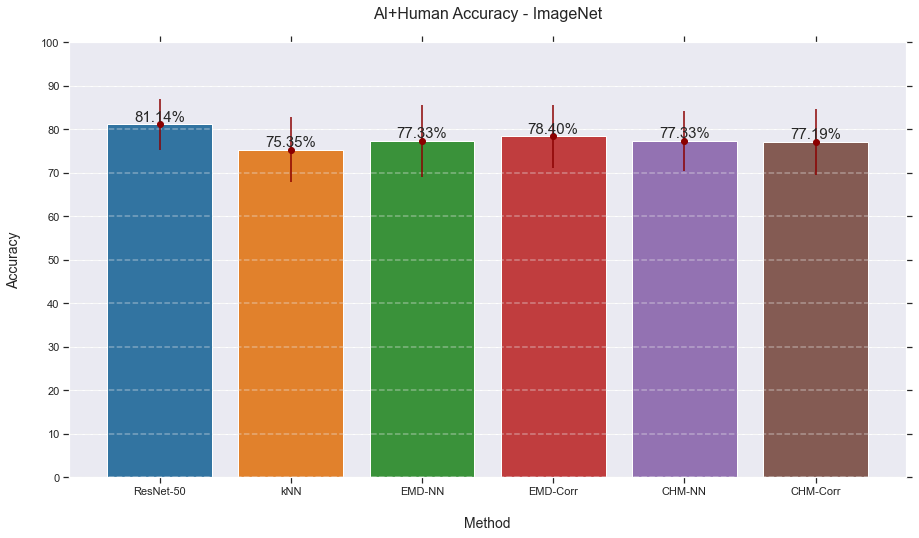

In [27]:
fig, ax = plt.subplots(1, figsize=(15, 8))
g = sns.barplot(data=df3_acc_even_ratio, x='Method', y='mean', ax=ax, palette="tab10", ci='std')

plt.title(f"AI+Human Accuracy - {DATA_SET}\n", fontsize=16)

plt.ylim(0, 100)
ax.set_yticks(range(0, 101, 10))
ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

for container in ax.containers:
  ax.bar_label(container, fontsize=15, fmt='%.2f%%')
    

vals = ax.get_yticks()
for tick in vals:
  ax.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

plt.errorbar(df3_acc_even_ratio['Method'], df3_acc_even_ratio['mean'], yerr=df3_acc_even_ratio['std'], fmt="o", color="darkred")

fig.savefig(f'../plots/human-study-main-results/ImageNet-evern-ratio.pdf' ,dpi=100, bbox_inches='tight')

ax.set_xlabel('Method', labelpad=20, fontsize=14)
ax.set_ylabel('Accuracy', labelpad=20, fontsize=14)

plt.show()

# Statistical Significance

In [28]:
from scipy.stats import mannwhitneyu
from statannotations.Annotator import Annotator

In [29]:
data_for_analysis = df2.groupby('Method')['even_sample_accuracy'].agg(lambda x: list(x)).reset_index().sort_values(by='Method', key=lambda x: x.map(ORDER_DICT))

In [30]:
data_for_analysis

,Method,even_sample_accuracy
4,ResNet-50,"[0.8692307692307689, 0.9030769230769231, 0.874..."
5,kNN,"[0.8274999999999991, 0.6776923076923081, 0.678..."
3,EMD-NN,"[0.7771428571428572, 0.769230769230769, 0.75, ..."
2,EMD-Corr,"[0.766666666666666, 0.7764285714285716, 0.7771..."
1,CHM-NN,"[0.833333333333333, 0.766666666666666, 0.78321..."
0,CHM-Corr,"[0.9333333333333335, 0.8127777777777773, 0.748..."


In [31]:
data_for_analysis['even_sample_accuracy']

4    [0.8692307692307689, 0.9030769230769231, 0.874...
5    [0.8274999999999991, 0.6776923076923081, 0.678...
3    [0.7771428571428572, 0.769230769230769, 0.75, ...
2    [0.766666666666666, 0.7764285714285716, 0.7771...
1    [0.833333333333333, 0.766666666666666, 0.78321...
0    [0.9333333333333335, 0.8127777777777773, 0.748...
Name: even_sample_accuracy, dtype: object

In [32]:
data_for_analysis_dict = {}
for i, row in data_for_analysis.iterrows():
  data_for_analysis_dict[row['Method']] = row['even_sample_accuracy']

In [33]:
pairs = [( 'ResNet-50', 'kNN'),
          ('ResNet-50', 'EMD-NN'),
          ('ResNet-50', 'EMD-Corr'),
          ('ResNet-50', 'CHM-NN'),
          ('ResNet-50', 'CHM-Corr'),
          ('kNN', 'EMD-NN'),
          ('kNN', 'EMD-Corr'),
          ('kNN', 'CHM-NN'),
          ('kNN', 'CHM-Corr'),
          ('EMD-NN', 'EMD-Corr'),
          ('EMD-NN', 'CHM-NN'),
          ('EMD-NN', 'CHM-Corr'),
          ('EMD-Corr', 'CHM-NN'),
          ('EMD-Corr', 'CHM-Corr'),
          ('CHM-NN', 'CHM-Corr')]

pvalues = [
  mannwhitneyu(data_for_analysis_dict['ResNet-50'], data_for_analysis_dict['kNN'], alternative="two-sided").pvalue,
  mannwhitneyu(data_for_analysis_dict['ResNet-50'], data_for_analysis_dict['EMD-NN'], alternative="two-sided").pvalue,
  mannwhitneyu(data_for_analysis_dict['ResNet-50'], data_for_analysis_dict['EMD-Corr'], alternative="two-sided").pvalue,
  mannwhitneyu(data_for_analysis_dict['ResNet-50'], data_for_analysis_dict['CHM-NN'], alternative="two-sided").pvalue,
  mannwhitneyu(data_for_analysis_dict['ResNet-50'], data_for_analysis_dict['CHM-Corr'], alternative="two-sided").pvalue,
  
  mannwhitneyu(data_for_analysis_dict['kNN'], data_for_analysis_dict['EMD-NN'], alternative="two-sided").pvalue,
  mannwhitneyu(data_for_analysis_dict['kNN'], data_for_analysis_dict['EMD-Corr'], alternative="two-sided").pvalue,
  mannwhitneyu(data_for_analysis_dict['kNN'], data_for_analysis_dict['CHM-NN'], alternative="two-sided").pvalue,
  mannwhitneyu(data_for_analysis_dict['kNN'], data_for_analysis_dict['CHM-Corr'], alternative="two-sided").pvalue,
  
  mannwhitneyu(data_for_analysis_dict['EMD-NN'], data_for_analysis_dict['EMD-Corr'], alternative="two-sided").pvalue,
  mannwhitneyu(data_for_analysis_dict['EMD-NN'], data_for_analysis_dict['CHM-NN'], alternative="two-sided").pvalue,
  mannwhitneyu(data_for_analysis_dict['EMD-NN'], data_for_analysis_dict['CHM-Corr'], alternative="two-sided").pvalue,
  
  mannwhitneyu(data_for_analysis_dict['EMD-Corr'], data_for_analysis_dict['CHM-NN'], alternative="two-sided").pvalue,
  mannwhitneyu(data_for_analysis_dict['EMD-Corr'], data_for_analysis_dict['CHM-Corr'], alternative="two-sided").pvalue,
  
  mannwhitneyu(data_for_analysis_dict['CHM-NN'], data_for_analysis_dict['CHM-Corr'], alternative="two-sided").pvalue,
]

formatted_pvalues = [f'p={pvalue:.2e}' for pvalue in pvalues]

In [34]:
selected_pairs = []
selected_pvalues = []
selected_pvalues_f = []

for pv, pi, fpv in  zip(pvalues, pairs, formatted_pvalues):
  if pv <= 0.05:
    selected_pairs.append(pi)
    selected_pvalues.append(pv)
    selected_pvalues_f.append(fpv)

In [35]:
df2.groupby('Method')['even_sample_accuracy'].agg(['mean', 'std']).reset_index().sort_values(by='Method', key=lambda x: x.map(ORDER_DICT))

,Method,mean,std
4,ResNet-50,0.811395,0.058033
5,kNN,0.753473,0.075524
3,EMD-NN,0.773320,0.083271
2,EMD-Corr,0.783969,0.073000
1,CHM-NN,0.773295,0.069638
0,CHM-Corr,0.771876,0.075787


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

ResNet-50 vs. kNN: Mann-Whitney-Wilcoxon test two-sided, P_val:3.755e-06 U_stat=2.640e+03
ResNet-50 vs. EMD-NN: Mann-Whitney-Wilcoxon test two-sided, P_val:1.834e-02 U_stat=2.143e+03
kNN vs. EMD-Corr: Mann-Whitney-Wilcoxon test two-sided, P_val:7.409e-03 U_stat=1.242e+03
ResNet-50 vs. CHM-NN: Mann-Whitney-Wilcoxon test two-sided, P_val:2.514e-03 U_stat=2.376e+03
ResNet-50 vs. CHM-Corr: Mann-Whitney-Wilcoxon test two-sided, P_val:1.603e-03 U_stat=2.364e+03


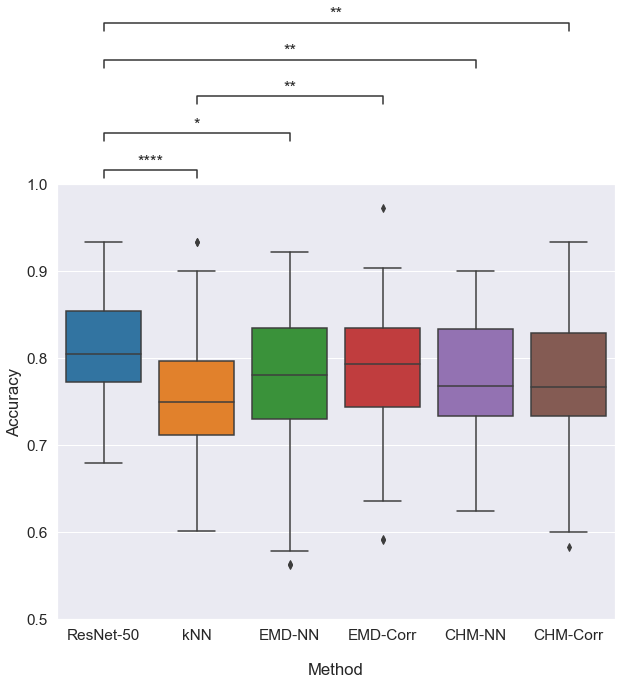

In [36]:
subcat_palette = sns.dark_palette("#8BF", reverse=True, n_colors=6)

plotting_parameters = {
    'data':    df2,
    'x':       'Method',
    'y':       'even_sample_accuracy',
    'palette': 'tab10'
}

with sns.plotting_context('notebook', font_scale = 1.4):
  # Create new plot
  fig, ax = plt.subplots(1, figsize=(10, 8), facecolor=(1,1,1))

  # Plot with seabornz
  sns.boxplot(**plotting_parameters)

  # Add annotations
  annotator = Annotator(ax, selected_pairs, **plotting_parameters)
  annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
  annotator.set_custom_annotations(selected_pvalues_f)
  annotator.apply_and_annotate()

  
  # Label and show
  ax.set_ylabel("Accuracy")
  ax.set_xlabel("Method", labelpad=20)
  fig.savefig(f'../plots/human-study-main-results/ImageNet-StatisticalDetails.pdf' ,dpi=100, bbox_inches='tight')
  plt.ylim(0.5, 1)
  plt.show()

In [37]:
# make the annotation gap smaller

In [ ]:
subcat_palette = sns.dark_palette("#8BF", reverse=True, n_colors=6)

plotting_parameters = {
    'data':    df2,
    'x':       'Method',
    'y':       'even_sample_accuracy',
    'palette': 'tab10'
}


with sns.plotting_context('paper', font_scale = 1.4):
  # Create new plot
  fig, ax = plt.subplots(1, figsize=(4, 2.5), facecolor=(1,1,1))

  # Plot with seabornz
  sns.boxplot(**plotting_parameters)

  # Add annotations
  annotator = Annotator(ax, selected_pairs, **plotting_parameters)
  annotator.configure(test='Mann-Whitney', text_format='star', loc='outside' , text_offset=-4)
  annotator.set_custom_annotations(selected_pvalues_f)
  annotator.apply_and_annotate( )

  # Label and show
  ax.set_ylabel("Accuracy")
  ax.set_xlabel("")

  plt.gca().set_ylim(bottom=0.5)
  plt.gca().set_ylim(top=1)
  plt.yticks(np.arange(0.5, 1.01, 0.1))
  plt.setp( ax.xaxis.get_majorticklabels(), rotation=35 ) 
  fig.savefig(f'../plots/human-study-main-results/ImageNet-StatisticalDetails-Slim.pdf', dpi=100, bbox_inches='tight')
  plt.show()